In [1]:
# Import All Lib
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.combine import SMOTETomek

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load Dataset

file = ('dataset/stroke_dataset.csv')
data = pd.read_csv(file)
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Mengenali Dataset

In [3]:
# Cek info dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# cek deskripsi data
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
# Cek nilai hilang pada dataset
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
# Terdapat 201 nilai yang hilang pada kolom BMI, kita akan lakukan pengisisan dengan nilai rata rata
# Mengisi Data yang tidak Ada Nilai nya
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())
print(data.isna().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [7]:
# cek duplikasi data
data.duplicated().sum()

0

In [8]:
# cek isian dari dataset

# gender
print(data['gender'].unique())

# worktype
print(data['work_type'].unique())

# Residence Type
print(data['Residence_type'].unique())

# Smoking Status
print(data['smoking_status'].unique())

['Male' 'Female' 'Other']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [9]:
# Menggahapus Nilai "Other" pada kolom gender
data = data[data['gender'] != 'Other']
data['gender'].unique()

array(['Male', 'Female'], dtype=object)

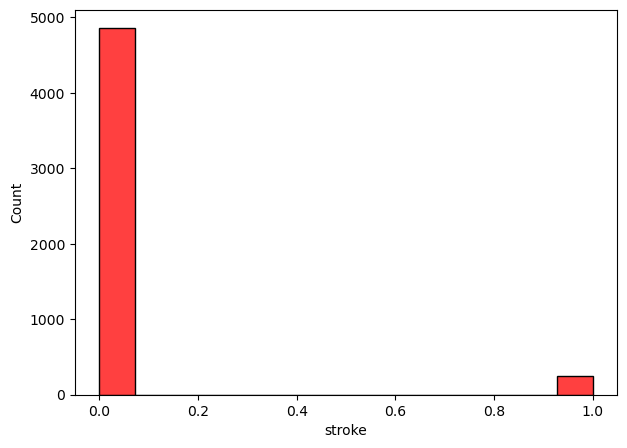

stroke
0    4860
1     249
Name: count, dtype: int64


In [10]:
# cek keseimbangan data
fig, axes = plt.subplots(1,1,figsize=(7,5))

sns.histplot(data = data, x='stroke', color = 'red')
plt.show()
print (data['stroke'].value_counts())

Terlihat Data belum seimbang

In [11]:
# Sebelum menyeimbangan Data ada beberapa tahapan lagi

#1. hapus kolom tidak berguna seperti ID
data.drop('id', axis=1, inplace=True)

#2. Transformasi Data menggunakan Label encoder
d_list = data.select_dtypes(include=['object']).columns.tolist()

le = LabelEncoder()
for i in d_list:
    le.fit(data[i])
    data[i] = le.transform(data[i])

C:\Users\jangh\AppData\Local\Temp\ipykernel_15728\583359724.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('id', axis=1, inplace=True)
C:\Users\jangh\AppData\Local\Temp\ipykernel_15728\583359724.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = le.transform(data[i])
C:\Users\jangh\AppData\Local\Temp\ipykernel_15728\583359724.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [12]:
# cek info dataset setelah transformasi
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int32  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int32  
 5   work_type          5109 non-null   int32  
 6   Residence_type     5109 non-null   int32  
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   int32  
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int32(5), int64(3)
memory usage: 379.2 KB


In [13]:
# Mengubah type data age menjadi INT
data['age'] = data['age'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int32  
 1   age                5109 non-null   int32  
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int32  
 5   work_type          5109 non-null   int32  
 6   Residence_type     5109 non-null   int32  
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   int32  
 10  stroke             5109 non-null   int64  
dtypes: float64(2), int32(6), int64(3)
memory usage: 359.2 KB


C:\Users\jangh\AppData\Local\Temp\ipykernel_15728\4286778755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age'] = data['age'].astype(int)


In [14]:
# Menentukan Label pada dataset

X = data.drop('stroke', axis=1)
y = data['stroke']

In [18]:
# Penyeimbangan Data
balanced = SMOTETomek(random_state=42)

X_resampled, y_resampled = balanced.fit_resample(X, y)

# Cek Jumlah Variabel X dan y Sebelum dan sesudah 
print('Jumlah sampel sebelum hybrid = ', len(X))
print('Jumlah sampel sesudah hybrid = ', len(X_resampled))

Jumlah sampel sebelum hybrid =  5109
Jumlah sampel sesudah hybrid =  9656


In [20]:
# Buat Menjadi Data Frame
resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['stroke'])], axis=1)
resampled_data.to_csv('stroke_dataset_balanced.csv', index=False)

In [21]:
# melihat apakah dataset sudah seimbang

data = pd.read_csv('stroke_dataset_balanced.csv')

data['stroke'].value_counts()

stroke
1    4828
0    4828
Name: count, dtype: int64

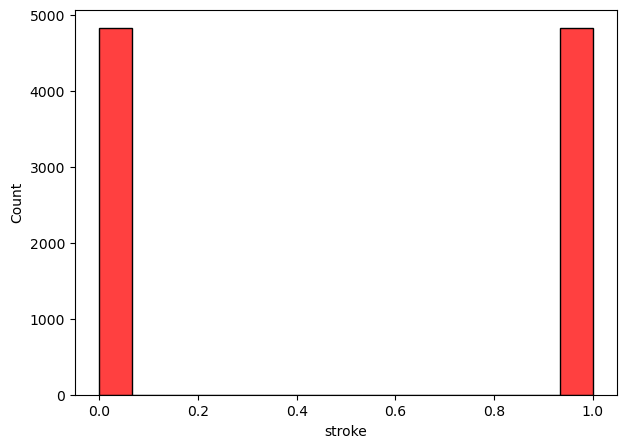

stroke
1    4828
0    4828
Name: count, dtype: int64


In [22]:
# Visualisasi Dataset yang sudah diseimbangakn
# cek keseimbangan data
fig, axes = plt.subplots(1,1,figsize=(7,5))

sns.histplot(data = data, x='stroke', color = 'red')
plt.show()
print (data['stroke'].value_counts())

In [24]:
# Pemilihan Variabel Bebas dan independent dari data yang sudah diseimbangakan
X = data.drop('stroke', axis=1)
y = data['stroke']

In [25]:
# Spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, shuffle=True)

In [30]:
# Implementasi Program

model = AdaBoostClassifier(
        estimator=RandomForestClassifier(n_estimators=100, random_state=42),
        n_estimators=100, algorithm="SAMME", random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print (model.score(X_test, y_test))

0.9497929606625258


Text(0.5, 1.0, 'Confus Matriks Random Forest')

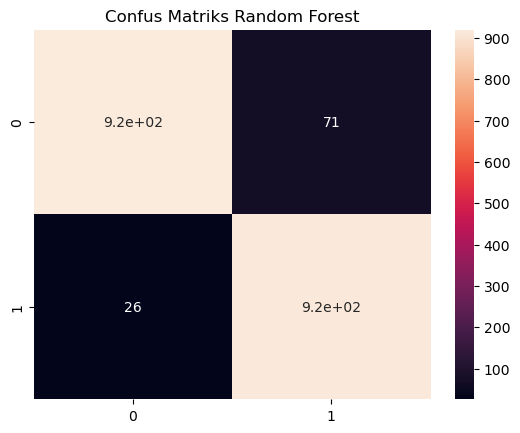

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
cn = confusion_matrix(y_test, pred)
sns.heatmap(cn, annot=True)
plt.title("Confus Matriks Random Forest")

In [33]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       991
           1       0.93      0.97      0.95       941

    accuracy                           0.95      1932
   macro avg       0.95      0.95      0.95      1932
weighted avg       0.95      0.95      0.95      1932



In [35]:
# Parameter grid yang sudah diperbaiki
param_grid = {
    'n_estimators': np.arange(2, 10),  # Perbaikan typo
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5),
    'min_samples_leaf': np.arange(1, 5),
    'min_samples_split': np.arange(1, 5),
    'max_features': ['sqrt'],  # Mengganti 'auto' dengan 'sqrt'
    'random_state': [10]
}

# Inisialisasi model
rf_model = RandomForestClassifier()

# Hyperparameter tuning dengan GridSearchCV
rf_hyper_model = GridSearchCV(rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
rf_hyper_model.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik
print("Best parameters:", rf_hyper_model.best_params_)


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
960 fits failed out of a total of 3840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
960 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-packa

Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 9, 'random_state': 10}


In [36]:
 rf_hyper_model.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 9,
 'random_state': 10}

In [37]:
rf_hyper_model.score(X_test, y_test)

0.8183229813664596

In [38]:
# Menyimpan Model yang dibuat

import pickle

pickle.dump(model, open('stroke2.pkl', 'wb'))